In [1]:
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau
import warnings

warnings.filterwarnings("ignore")

# Dataset paths
# Paths for data.
Ravdess = "C:\\Users\\Anuj Chouhan\\PycharmProjects\\PythonP-3\\datasets\\uwrfkaggler\\ravdess-emotional-speech-audio\\versions\\1\\audio_speech_actors_01-24"
Crema = "C:\\Users\\Anuj Chouhan\\PycharmProjects\\PythonP-3\\datasets\\ejlok1\\cremad\\versions\\1\\AudioWAV"
Tess = "C:\\Users\\Anuj Chouhan\\PycharmProjects\\PythonP-3\\datasets\ejlok1\\toronto-emotional-speech-set-tess\\versions\\1\\TESS Toronto emotional speech set data\\TESS Toronto emotional speech set data"
Savee = "C:\\Users\\Anuj Chouhan\\PycharmProjects\\PythonP-3\\datasets\\ejlok1\\surrey-audiovisual-expressed-emotion-savee\\versions\\1\\ALL"


In [4]:

# Function to load Ravdess dataset
def load_ravdess(path):
    data = []
    for dir in os.listdir(path):
        dir_path = os.path.join(path, dir)
        if not os.path.isdir(dir_path):
            continue
        for file in os.listdir(dir_path):
            if not file.endswith(".wav"):
                continue
            emotion = int(file.split("-")[2])
            label = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}.get(emotion)
            data.append([label, os.path.join(dir_path, file)])
    return pd.DataFrame(data, columns=["Emotions", "Path"])

# Function to load Crema dataset
def load_crema(path):
    data = []
    for file in os.listdir(path):
        if not file.endswith(".wav"):
            continue
        emotion = file.split('_')[2]
        label = {'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'}.get(emotion, 'unknown')
        data.append([label, os.path.join(path, file)])
    return pd.DataFrame(data, columns=["Emotions", "Path"])

# Function to load Tess dataset
def load_tess(path):
    data = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            if not file.endswith(".wav"):
                continue
            emotion = file.split("_")[-1].split(".")[0].lower()
            emotion = 'surprise' if emotion == 'ps' else emotion
            data.append([emotion, os.path.join(folder_path, file)])
    return pd.DataFrame(data, columns=["Emotions", "Path"])

# Function to load Savee dataset
def load_savee(path):
    data = []
    for file in os.listdir(path):
        if not file.endswith(".wav"):
            continue
        code = file.split("_")[1][:-6]
        label = {'a': 'angry', 'd': 'disgust', 'f': 'fear', 'h': 'happy', 'n': 'neutral', 'sa': 'sad'}.get(code, 'surprise')
        data.append([label, os.path.join(path, file)])
    return pd.DataFrame(data, columns=["Emotions", "Path"])

# Load and print stats
ravdess_df = load_ravdess(Ravdess)
crema_df = load_crema(Crema)
tess_df = load_tess(Tess)
savee_df = load_savee(Savee)

print(f"RAVDESS files loaded: {len(ravdess_df)}")
print(f"CREMA files loaded: {len(crema_df)}")
print(f"TESS files loaded: {len(tess_df)}")
print(f"SAVEE files loaded: {len(savee_df)}")

# Combine datasets
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], ignore_index=True)
print(f"Total audio samples collected: {len(data_path)}")


RAVDESS files loaded: 1440
CREMA files loaded: 7442
TESS files loaded: 2800
SAVEE files loaded: 480
Total audio samples collected: 12162


In [5]:
# Feature Extraction
def extract_features(data, sr):
    features = []
    features.extend(np.mean(librosa.feature.zero_crossing_rate(data).T, axis=0))
    stft = np.abs(librosa.stft(data))
    features.extend(np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0))
    features.extend(np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0))
    features.extend(np.mean(librosa.feature.rms(y=data).T, axis=0))
    features.extend(np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0))
    return np.array(features)

# Data Augmentation



In [6]:
def noise(data):
    return data + 0.035 * np.random.uniform() * np.amax(data) * np.random.normal(size=data.shape)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sr, factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=factor)

In [7]:


# Build dataset with augmentation
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    try:
        data, sr = librosa.load(path, duration=2.5, offset=0.6)
        for variant in [data, noise(data), pitch(stretch(data), sr)]:
            features = extract_features(variant, sr)
            if features.shape[0] > 0:
                X.append(features)
                Y.append(emotion)
    except Exception as e:
        print(f"Skipping file {path} due to error: {e}")
        continue

print(f"Total processed feature vectors: {len(X)}")

# Abort if no data found
if len(Y) == 0:
    raise ValueError("No valid audio samples were processed. Please verify dataset paths and formats.")



Total processed feature vectors: 36486


In [8]:
# Encode and split
X = np.array(X)
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [9]:
# CNN model
model = Sequential([
    Conv1D(256, 5, activation='relu', padding='same', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu', padding='same'),
    MaxPooling1D(5),
    Dropout(0.3),
    Conv1D(64, 5, activation='relu', padding='same'),
    MaxPooling1D(5),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(Y.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:


# Train
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=1e-7)
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
457/457 [==============================] - 41s 86ms/step - loss: 1.7210 - accuracy: 0.3101 - val_loss: 1.4365 - val_accuracy: 0.4272 - lr: 0.0010
Epoch 2/50
457/457 [==============================] - 42s 92ms/step - loss: 1.4681 - accuracy: 0.4167 - val_loss: 1.3073 - val_accuracy: 0.4912 - lr: 0.0010
Epoch 3/50
457/457 [==============================] - 70s 154ms/step - loss: 1.3907 - accuracy: 0.4506 - val_loss: 1.3168 - val_accuracy: 0.4804 - lr: 0.0010
Epoch 4/50
457/457 [==============================] - 74s 163ms/step - loss: 1.3366 - accuracy: 0.4687 - val_loss: 1.2242 - val_accuracy: 0.5133 - lr: 0.0010
Epoch 5/50
457/457 [==============================] - 88s 193ms/step - loss: 1.3005 - accuracy: 0.4834 - val_loss: 1.1943 - val_accuracy: 0.5195 - lr: 0.0010
Epoch 6/50
457/457 [==============================] - 38s 84ms/step - loss: 1.2652 - accuracy: 0.4958 - val_loss: 1.1804 - val_accuracy: 0.5322 - lr: 0.0010
Epoch 7/50
457/457 [==============================] - 3

In [11]:
# Evaluate
score = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {score[1]*100:.2f}%")

229/229 [==============================] - 3s 14ms/step - loss: 0.9907 - accuracy: 0.6032
Test Accuracy: 60.32%


In [12]:
# Save model
model.save("emotion_detection_model.h5")
print("Model saved as emotion_detection_model.h5")

Model saved as emotion_detection_model.h5


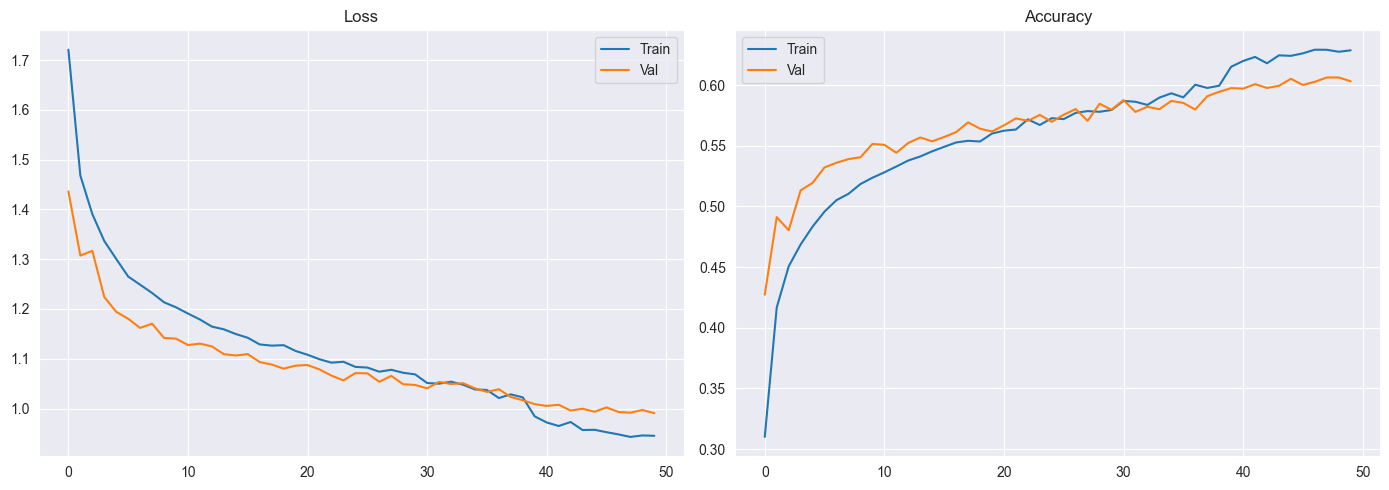

In [13]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()